In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# Video segmentation with SAM 2

This notebook shows how to use SAM 2 for interactive segmentation in videos. It will cover the following:

- adding clicks on a frame to get and refine _masklets_ (spatio-temporal masks) 
- propagating clicks to get _masklets_ throughout the video
- segmenting and tracking multiple objects at the same time

We use the terms _segment_ or _mask_ to refer to the model prediction for an object on a single frame, and _masklet_ to refer to the spatio-temporal masks across the entire video. 

If running locally using jupyter, first install `segment-anything-2` in your environment using the [installation instructions](https://github.com/facebookresearch/segment-anything-2#installation) in the repository.

In [2]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [3]:
# use bfloat16 for the entire notebook
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

### Loading the SAM 2 video predictor

In [4]:
from sam2.build_sam import build_sam2_video_predictor

sam2_checkpoint = "../checkpoints/sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint)

/mnt/md126/users/mohamed/projects/segment-anything-2/sam2/modeling/sam/transformer.py:23: UserWarning: Flash Attention is disabled as it requires a GPU with Ampere (8.0) CUDA capability.
  OLD_GPU, USE_FLASH_ATTN, MATH_KERNEL_ON = get_sdpa_settings()


In [5]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

def sort_and_filter_images(directory, keyword):
    """
    Scans a directory for JPEG images, filters those that include a specific keyword in the filename,
    and sorts them based on the integer value that appears after 'f_' in the filename.

    Parameters:
    - directory (str): The path to the directory containing the images.
    - keyword (str): The keyword to filter filenames by (e.g., '_c1').

    Returns:
    - List[str]: A list of filtered and sorted filenames.
    """
    # Scan all the JPEG frame names in the directory
    frame_names = [
        p for p in os.listdir(directory)
        if os.path.splitext(p)[-1].lower() in [".jpg", ".jpeg"]
    ]

    # Filter to include only images that contain the keyword
    filtered_frames = [name for name in frame_names if keyword in name]

    # Sort by the integer number after 'f_'
    filtered_frames.sort(key=lambda name: int(name.split('_f_')[1].split('_')[0]))

    return filtered_frames
def sample_points(mask, num_samples):
    if num_samples == 0:
        return np.array([[]])
    """Sample points where the mask is True."""
    # Find indices where the mask is True
    y_indices, x_indices = np.where(mask)
    total_points = len(x_indices)
    if num_samples > total_points:
        raise ValueError(f"num_samples ({num_samples}) should be less than or equal to the total number of points ({total_points}).")
    # Randomly select `num_samples` points
    chosen_indices = np.random.choice(len(x_indices), num_samples, replace=False)
    # Extract the corresponding points
    sampled_points = np.array(list(zip(x_indices[chosen_indices], y_indices[chosen_indices])), dtype=np.float32)
    return sampled_points


#### Select an example video

We assume that the video is stored as a list of JPEG frames with filenames like `<frame_index>.jpg`.

For your custom videos, you can extract their JPEG frames using ffmpeg (https://ffmpeg.org/) as follows:
```
ffmpeg -i <your_video>.mp4 -q:v 2 -start_number 0 <output_dir>/'%05d.jpg'
```
where `-q:v` generates high-quality JPEG frames and `-start_number 0` asks ffmpeg to start the JPEG file from `00000.jpg`.

#### Initialize the inference state

In [6]:
import os
import shutil  # Import shutil for file operations

# Original directory where the video frames are stored
video_dir1 = "/mnt/md126/users/mohamed/projects/AM/Data/RAW/ByDay/20240712/CRED/20240708_09_00/CREDgt_set_4/Original"
masks_directory = "/mnt/md126/users/mohamed/projects/AM/Data/RAW/ByDay/20240712/CRED/20240708_09_00/CREDgt_set_4/Masks"
raw_video_dir = "/mnt/md126/users/mohamed/projects/AM/Data/RAW/ByDay/20240712/CRED/20240708_09_00/20240708_09_00_12072024_113101.raw"
video_dir2 = "/mnt/md126/users/mohamed/projects/AM/Data/Processed/JPEG/ByDay/20240712/gt_set_4"

# Temporary directory to save reordered frames
temp_dir = "/home/mohamed/data2/projects/segment-anything-2/notebooks/videos/CREDgt_set_4/"
os.makedirs(temp_dir, exist_ok=True)  # Create the temp directory if it doesn't exist
frame_names_1 = sort_and_filter_images(video_dir1, "_c1")   #Frames that have masks
frame_names_2 = sort_and_filter_images(video_dir2, "_c1")   


frame_names = list(set(frame_names_1 + frame_names_2))
frame_names.sort(key=lambda name: int(name.split('_f_')[1].split('_')[0]))

labels_index = []
for frame in frame_names_1:
    labels_index.append(frame_names.index(frame))

flood_masks = sort_and_filter_images(masks_directory, "_c1")   # Sort and filter the images
voids_masks = sort_and_filter_images(masks_directory, "_c2")   # Sort and filter the images
# Save the sorted images into the temp directory with new filenames
for index, filename in enumerate(frame_names, start=1):
    if filename in frame_names_1:
        video_dir = video_dir1
    elif filename in frame_names_2:
        video_dir = video_dir2
    source_path = os.path.join(video_dir, filename)
    dest_path = os.path.join(temp_dir, f"{index}.jpg")
    shutil.copy(source_path, dest_path)  # Copy the file to the new location with a new filename
print(f"Sorted and copied {len(frame_names)} files to {temp_dir}")


Sorted and copied 969 files to /home/mohamed/data2/projects/segment-anything-2/notebooks/videos/CREDgt_set_4/


SAM 2 requires stateful inference for interactive video segmentation, so we need to initialize an **inference state** on this video.

During initialization, it loads all the JPEG frames in `video_path` and stores their pixels in `inference_state` (as shown in the progress bar below).

In [8]:
inference_state = predictor.init_state(video_path=temp_dir)

frame loading (JPEG): 100%|██████████| 969/969 [00:32<00:00, 30.12it/s]


### Example 1: Segment & track one object

Note: if you have run any previous tracking using this `inference_state`, please reset it first via `reset_state`.

(The cell below is just for illustration; it's not needed to call `reset_state` here as this `inference_state` is just freshly initialized above.)

In [11]:
predictor.reset_state(inference_state)

#### Step 1: Coverting Human Mask Into Postive and Negative Points

To get started, let's try to segment the child on the left.


Here we make a **positive click** at (x, y) = (210, 350) with label `1`, by sending their coordinates and labels into the `add_new_points` API.

Note: label `1` indicates a *positive click (to add a region)* while label `0` indicates a *negative click (to remove a region)*.

/mnt/md126/users/mohamed/projects/segment-anything-2/sam2/sam2_video_predictor.py:810: UserWarning: cannot import name '_C' from 'sam2' (/mnt/md126/users/mohamed/projects/segment-anything-2/sam2/__init__.py)

Skipping the post-processing step due to the error above. Consider building SAM 2 with CUDA extension to enable post-processing (see https://github.com/facebookresearch/segment-anything-2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(


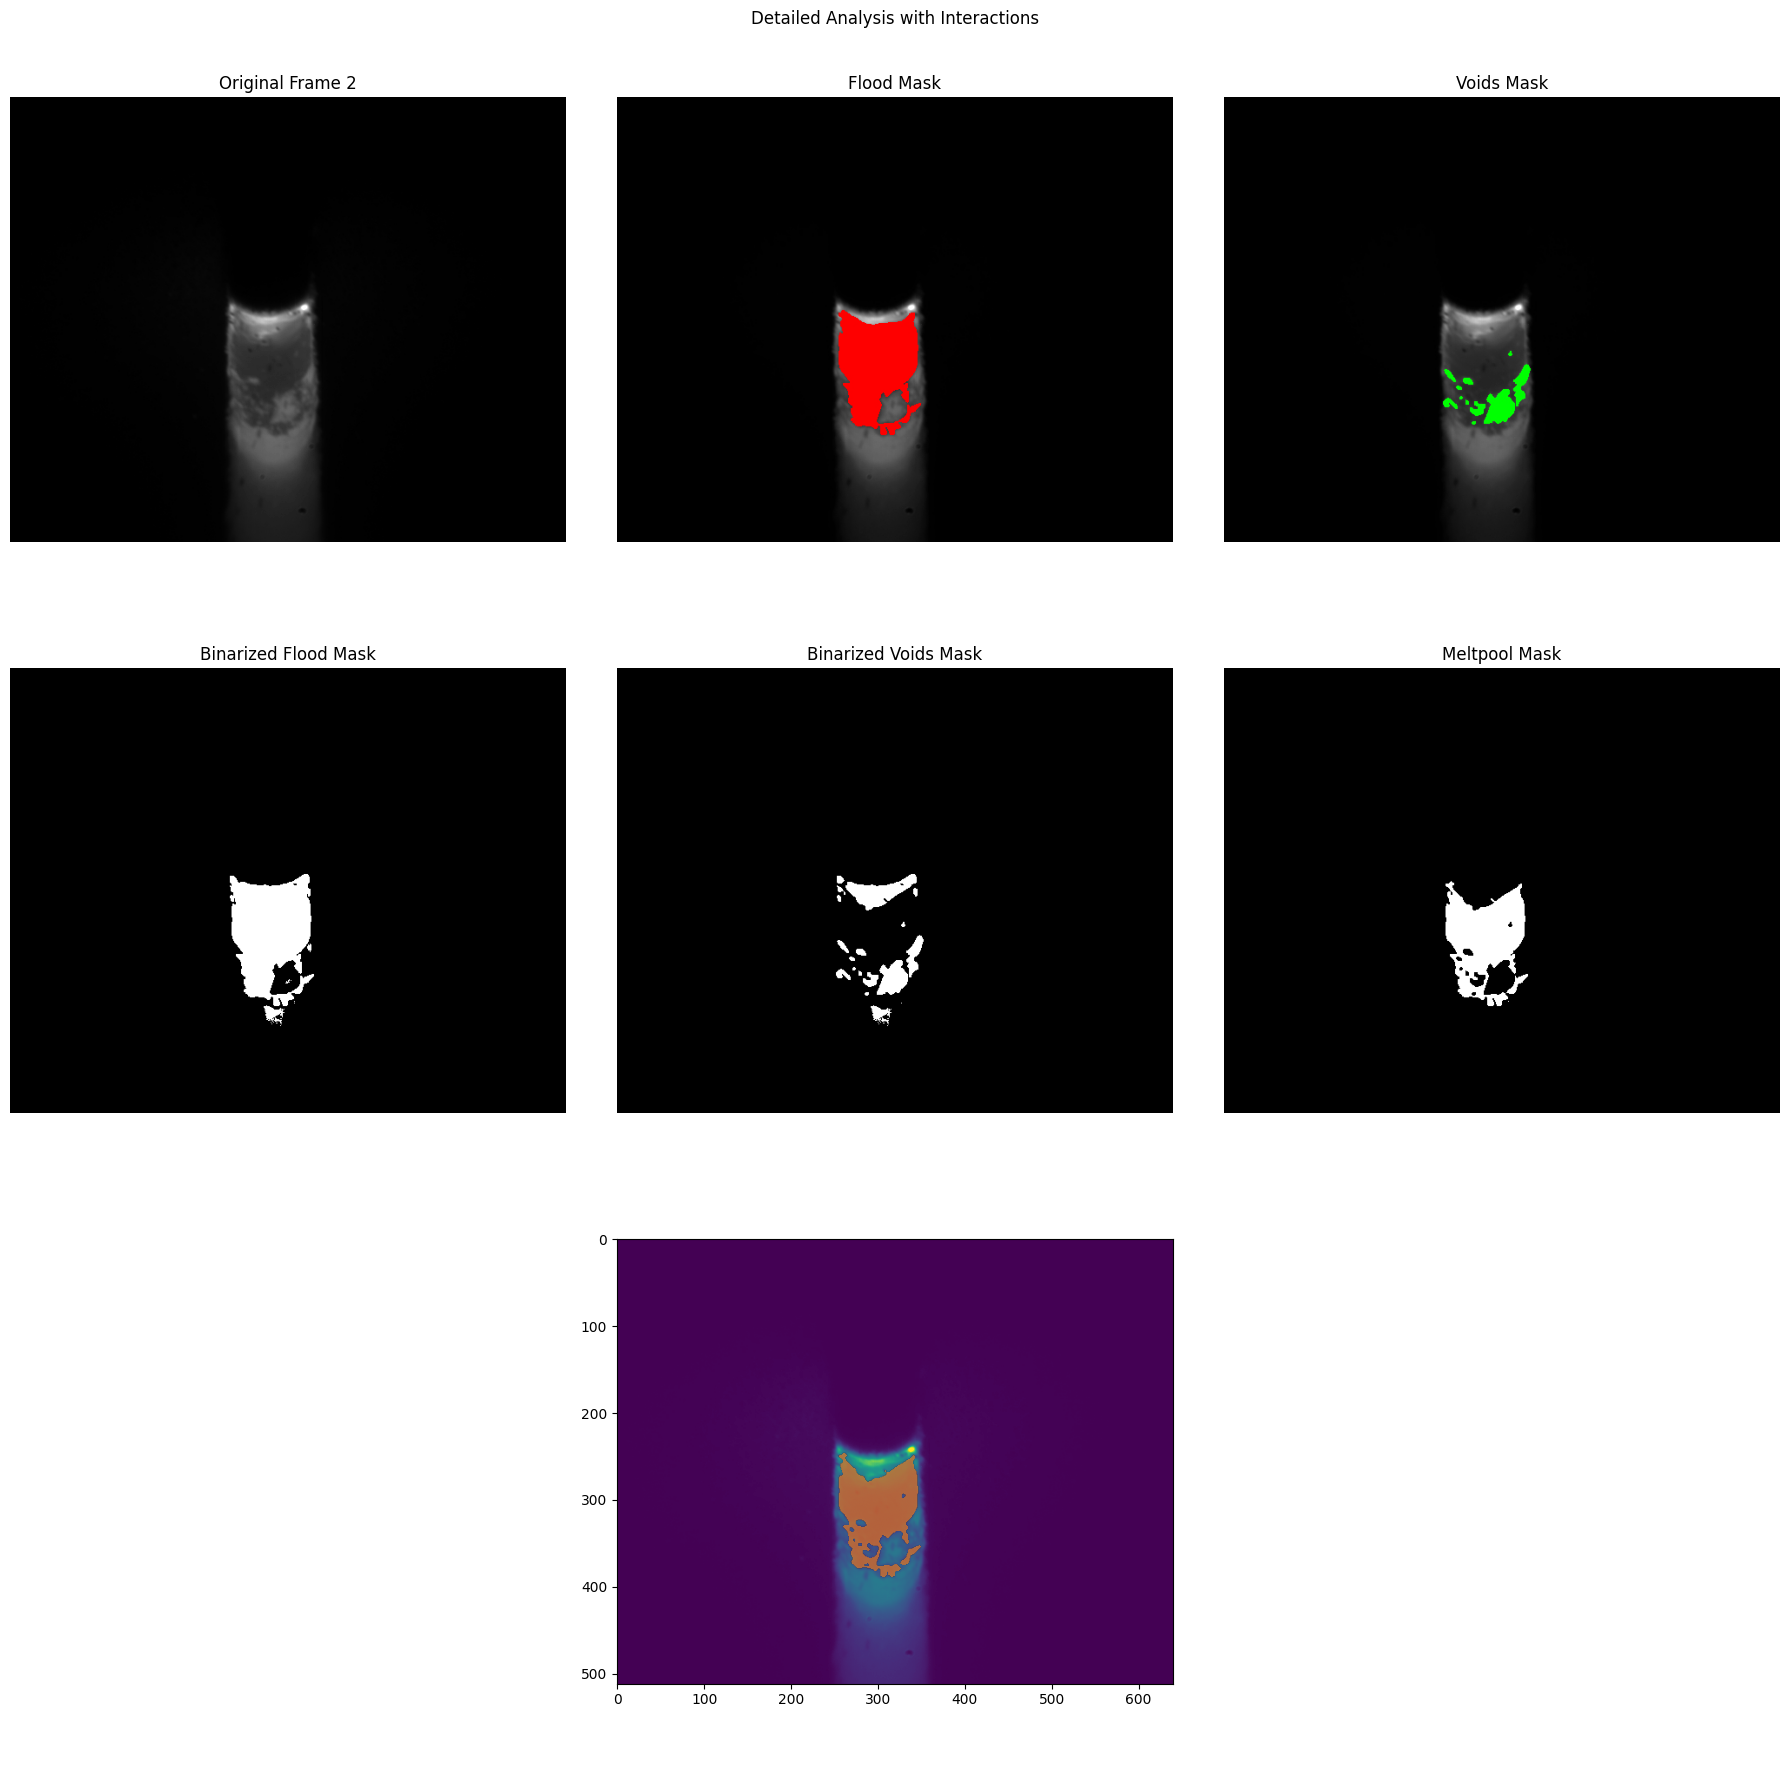

In [12]:
#label_idx = 0
#for label_idx in range(0, len(labels_index)):
for label_idx in [1]:
    frame_idx = labels_index[label_idx] + 1

    # Load the image and masks
    image = Image.open(os.path.join(temp_dir, f"{frame_idx}.jpg"))
    flood_mask = Image.open(os.path.join(masks_directory, flood_masks[label_idx]))
    voids_mask = Image.open(os.path.join(masks_directory, voids_masks[label_idx]))

    # Convert masks to binary arrays
    flood_mask_binary = np.array(flood_mask)[:, :, 0] > 100  # Extract red channel
    void_mask_binary = np.array(voids_mask)[:, :, 1] > 100  # Extract green channel

    # Create the meltpool and background masks
    meltpool_mask = flood_mask_binary & ~void_mask_binary
    background_mask = ~meltpool_mask




    sample_points_p = sample_points(meltpool_mask, 10)
    sample_points_n = sample_points(background_mask, 10)
    sample_points_n_2 = sample_points(void_mask_binary, 10) 
    points = np.concatenate([sample_points_p, sample_points_n, sample_points_n_2], axis=0)
    labels = np.concatenate([np.ones(len(sample_points_p)), np.zeros(len(sample_points_n)), np.zeros(len(sample_points_n_2))], axis=0)

    ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)

    # for labels, `1` means positive click and `0` means negative click

    # _, out_obj_ids, out_mask_logits = predictor.add_new_points(
    #     inference_state=inference_state,
    #     frame_idx=frame_idx-1,
    #     obj_id=ann_obj_id,
    #     points=points,
    #     labels=labels,
    # )
    _, out_obj_ids, out_mask_logits = predictor.add_new_mask(
        inference_state=inference_state,
        frame_idx=frame_idx-1,
        obj_id=ann_obj_id,
        mask=meltpool_mask,

    )

    # Create a figure with 3x3 subplots to include additional visualizations
    fig, axs = plt.subplots(3, 3, figsize=(18, 18))
    fig.suptitle('Detailed Analysis with Interactions')

    # First row: Original image and two masks
    axs[0, 0].imshow(image, cmap="gray")
    axs[0, 0].set_title(f"Original Frame {frame_idx}")
    axs[0, 0].axis('off')

    axs[0, 1].imshow(flood_mask, cmap="gray")
    axs[0, 1].set_title("Flood Mask")
    axs[0, 1].axis('off')

    axs[0, 2].imshow(voids_mask, cmap="gray")
    axs[0, 2].set_title("Voids Mask")
    axs[0, 2].axis('off')

    # Second row: Binarized masks
    axs[1, 0].imshow(flood_mask_binary, cmap='gray')
    axs[1, 0].set_title('Binarized Flood Mask')
    axs[1, 0].axis('off')

    axs[1, 1].imshow(void_mask_binary, cmap='gray')
    axs[1, 1].set_title('Binarized Voids Mask')
    axs[1, 1].axis('off')

    axs[1, 2].imshow(meltpool_mask, cmap='gray')
    axs[1, 2].set_title('Meltpool Mask')
    axs[1, 2].axis('off')


    # axs[2, 0].imshow(image)
    # show_points(points, labels, axs[2, 0])  # Assuming points and labels are defined
    axs[2, 0].axis('off')

    axs[2, 1].imshow(image)
    show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), axs[2, 1], out_obj_ids[0])  # Assuming mask logits and object IDs are defined

    # Hide the last subplot as it's unused
    axs[2, 2].axis('off')

    plt.tight_layout()
    plt.show()

#### Step 3: Propagate the prompts to get the masklet across the video

To get the masklet throughout the entire video, we propagate the prompts using the `propagate_in_video` API.

In [13]:
# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

propagate in video: 100%|██████████| 968/968 [07:26<00:00,  2.17it/s]


In [ ]:


# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(temp_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

In [ ]:
for index, filename in enumerate(frame_names, start=1):
    if filename in frame_names_1:
        video_dir = video_dir1
    elif filename in frame_names_2:
        video_dir = video_dir2
    source_path = os.path.join(video_dir, filename)
    dest_path = os.path.join(temp_dir, f"{index}.jpg")
    shutil.copy(source_path, dest_path)  # Copy the file to the new location with a new filename
print(f"Sorted and copied {len(frame_names)} files to {temp_dir}")

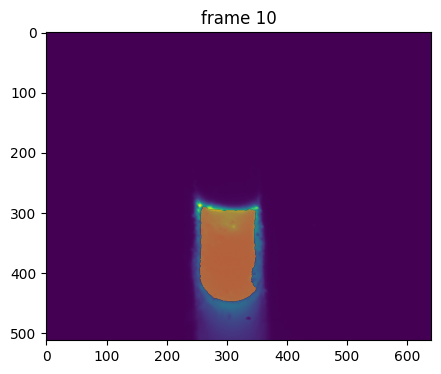

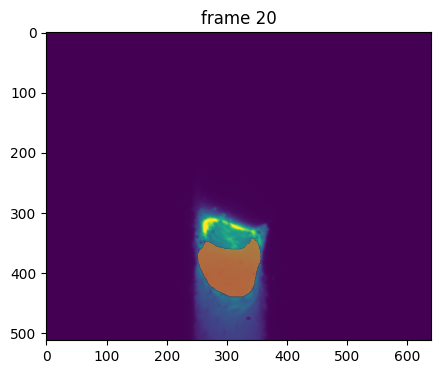

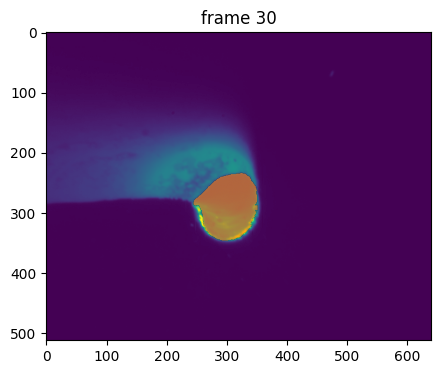

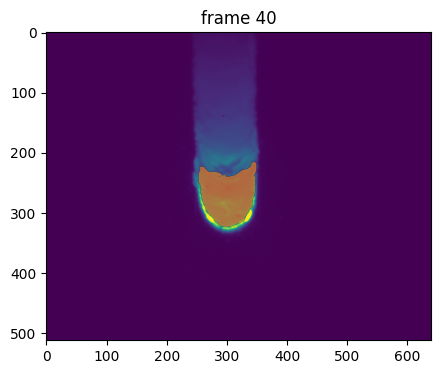

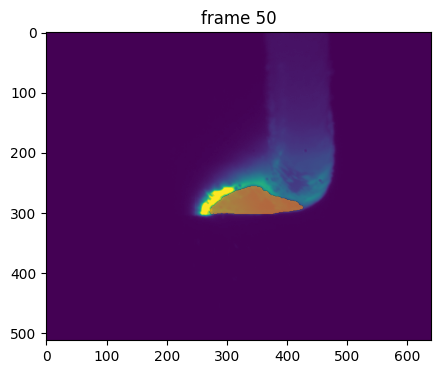

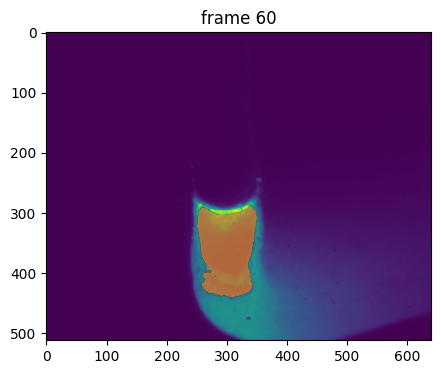

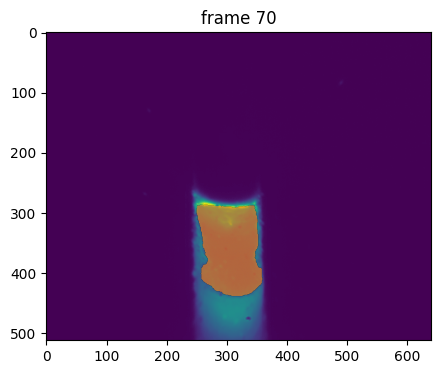

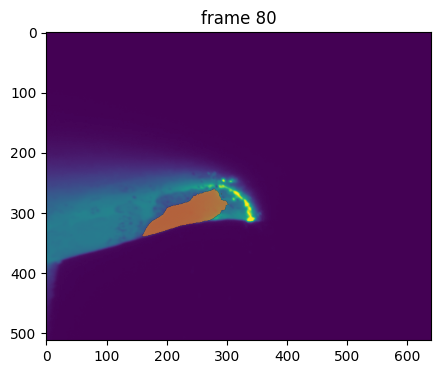

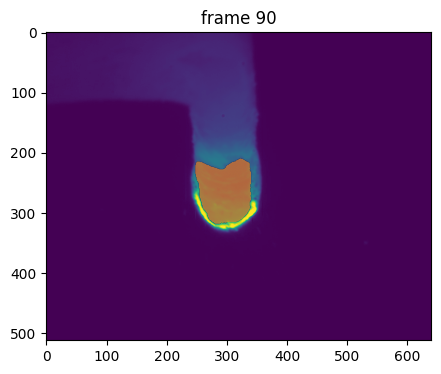

In [17]:
# render the segmentation results every few frames
vis_frame_stride = 10
plt.close("all")
for out_frame_idx in range(10, 100, vis_frame_stride):
#for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    filename = frame_names[out_frame_idx]
    if filename in frame_names_1:
        video_dir = video_dir1
    elif filename in frame_names_2:
        video_dir = video_dir2
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(Image.open(os.path.join(video_dir, f'{filename}')))
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)